Random Projection vs PCA

Begin importing dataset and understanding number of classes/features

In [1]:
from sklearn.datasets import fetch_rcv1
from sklearn.model_selection import train_test_split

rcv1 = fetch_rcv1(shuffle=True, random_state=0)
print(f"Data shape: {rcv1.data.shape}")

X, Y = rcv1.data, rcv1.target      # X: (n_samples, n_features), Y: multilabel CSR
names = rcv1.target_names

Data shape: (804414, 47236)


Create Random Projection Set

Create GuassianRandomProjetion and TSNE variables for dimensionality reduction. Then loop through the dataset in batches to make this less expensive. 

In [2]:
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

n_samples = X.shape[0]
batch_size = 10000
proj_dim = 50
rng = np.random.default_rng(42)
transformer = SparseRandomProjection(n_components=proj_dim, random_state=0, dense_output=False)
transformer.fit(X[:min(1000, n_samples)])

,n_components,50
,density,'auto'
,eps,0.1
,dense_output,False
,compute_inverse_components,False
,random_state,0


Sample in batches to make processing more memory friendly 

In [3]:
import scipy.sparse as sp
Z_batches = []
Y_batches = []

for start in range(0, n_samples, batch_size):
    end = min(start + batch_size, n_samples)
    Z_batches.append(transformer.transform(X[start:end]))   # stays sparse
    Y_batches.append(Y[start:end])                          # keep native type

# ----- concatenate Z -----
Z = np.vstack([z.toarray().astype(np.float32, copy=False) for z in Z_batches])  # dense after RP

# ----- concatenate Y robustly -----
# 1) If labels are sparse one-hot
if sp.issparse(Y_batches[0]):
    Y_all = sp.vstack(Y_batches, format='csr')
# 2) If labels are dense 2D (one-hot)
elif isinstance(Y_batches[0], np.ndarray) and Y_batches[0].ndim == 2:
    Y_all = np.vstack(Y_batches)
# 3) If labels are 1D integers
else:
    Y_all = np.concatenate(Y_batches, axis=0)

# ----- get flat label vector matching Z rows -----
if sp.issparse(Y_all):
    # sparse one-hot -> argmax per row
    labels_all = np.asarray(Y_all.argmax(axis=1)).ravel()
elif isinstance(Y_all, np.ndarray) and Y_all.ndim == 2 and Y_all.shape[1] > 1:
    # dense one-hot
    labels_all = Y_all.argmax(axis=1)
else:
    # already 1D labels
    labels_all = np.asarray(Y_all).ravel()

# sanity check
assert Z.shape[0] == labels_all.shape[0], f"Row mismatch: Z={Z.shape[0]} vs labels={labels_all.shape[0]}"

# ----- 25% subsample for t-SNE -----
subset_size = max(1, int(0.25 * Z.shape[0]))
idx = rng.choice(Z.shape[0], size=subset_size, replace=False)
Z_small = Z[idx]
labels_small = labels_all[idx]

# ----- t-SNE
tsne = TSNE(n_components=2, random_state=42, init="pca", learning_rate="auto")
Z_2d = tsne.fit_transform(Z_small)

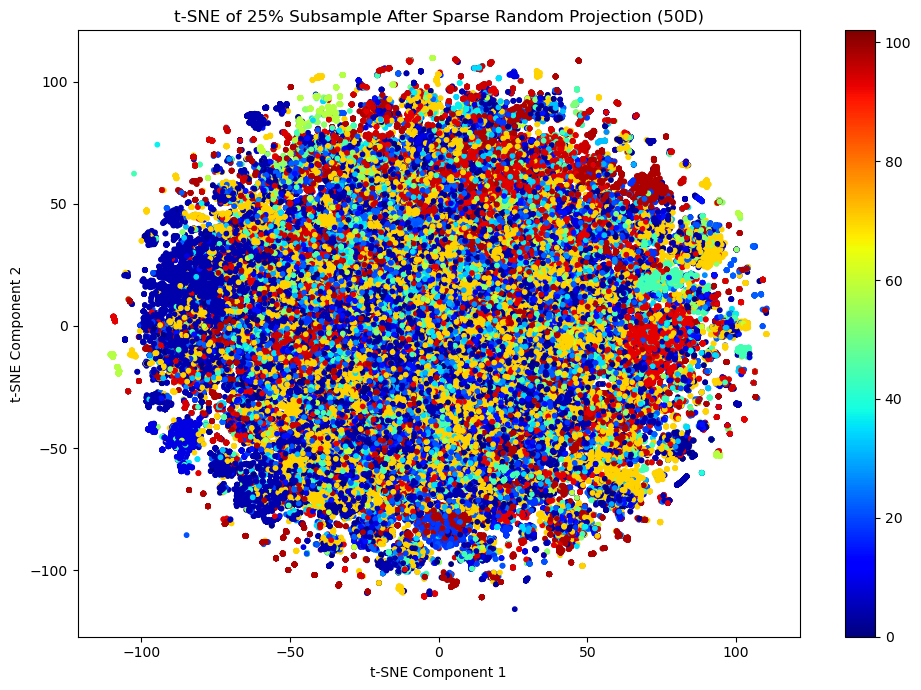

In [4]:
plt.figure(figsize=(10, 7))
plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=labels_small, cmap='jet', s=10)
plt.colorbar()
plt.title('t-SNE of 25% Subsample After Sparse Random Projection ({}D)'.format(proj_dim))
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()

Compare with PCA

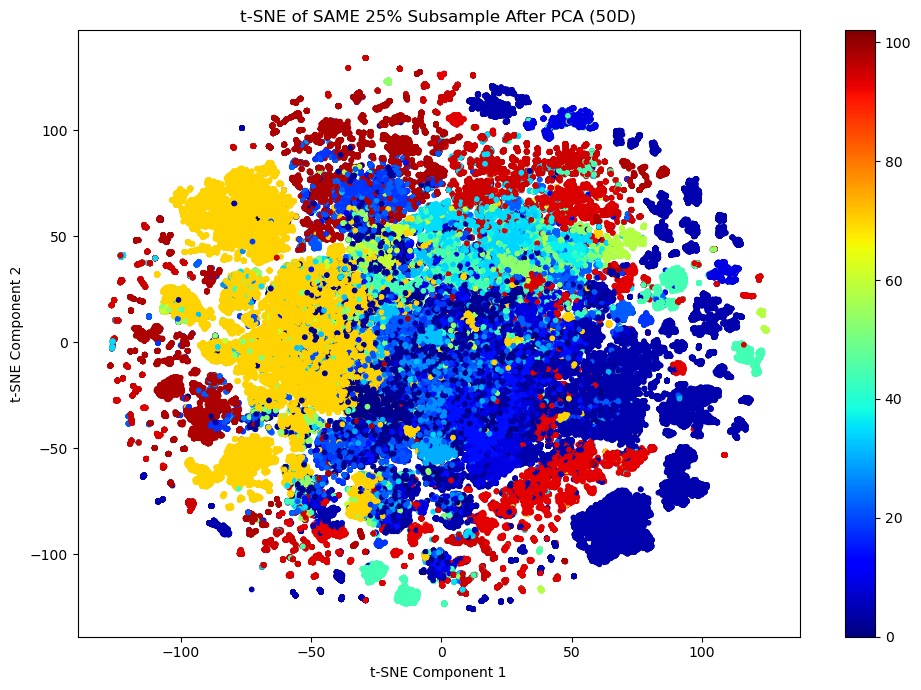

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import sparse as sp

# --- Assumes X (sparse), Y (1D or one-hot), and possibly idx already exist ---

n_samples = X.shape[0]
rng = np.random.default_rng(42)

# Reuse the same subset if idx exists; otherwise recreate deterministically (25%)
if "idx" in globals() and isinstance(idx, np.ndarray) and idx.ndim == 1:
    pass  # keep existing idx
else:
    subset_size = max(1, int(0.25 * n_samples))
    idx = rng.choice(n_samples, size=subset_size, replace=False)

# Slice the SAME chunk
X_sub = X[idx]                      # stays sparse here
# Build label vector for the subset
if sp.issparse(Y):
    labels_sub = np.asarray(Y[idx].argmax(axis=1)).ravel()
elif isinstance(Y, np.ndarray) and Y.ndim == 2 and Y.shape[1] > 1:
    labels_sub = Y[idx].argmax(axis=1)
else:
    labels_sub = np.asarray(Y)[idx].ravel()

# Densify only the subset (safe because it's just 25%)
X_sub_dense = X_sub.toarray().astype(np.float32, copy=False)

# --- PCA to 50D (use randomized solver for speed + reproducibility) ---
pca = PCA(n_components=50, svd_solver='randomized', random_state=0)
X_pca = pca.fit_transform(X_sub_dense)

# --- t-SNE to 2D for visualization ---
tsne = TSNE(n_components=2, random_state=42, init="pca", learning_rate="auto")
X_tsne = tsne.fit_transform(X_pca)

# --- Plot ---
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_sub, cmap='jet', s=10)
plt.colorbar()
plt.title("t-SNE of SAME 25% Subsample After PCA (50D)")
plt.xlabel("t-SNE Component 1"); plt.ylabel("t-SNE Component 2")
plt.tight_layout(); plt.show()

PCA seperates data much more efficiently, this should allow for seperation of data to be more efficient in the long run. The goal now is to use more components, such as 100+.

Getting a baseline for a Logistic SVD classifier

In [7]:
from sklearn.datasets import fetch_rcv1
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

# Load sparse TF-IDF features X (csr) and multilabel Y (csr)
rcv1 = fetch_rcv1(shuffle=True, random_state=42)
X, Y = rcv1.data, rcv1.target  # X: (n_samples, n_features) CSR, Y: multilabel CSR
classes = rcv1.target_names

# Train/val/test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
X_train, X_val,  Y_train, Y_val  = train_test_split(
    X_train, Y_train, test_size=0.1, random_state=42
)

clf = OneVsRestClassifier(
    SGDClassifier(
        loss="log_loss",        # logistic regression (probabilistic)
        alpha=1e-5,             # L2 strength
        max_iter=20,            # do a few passes; increase if needed
        tol=1e-3,
        n_jobs=-1,
        class_weight=None,      # try "balanced" if imbalance hurts recall
        random_state=42
    ),
    n_jobs=-1
)

clf.fit(X_train, Y_train)
Y_val_pred = clf.predict(X_val)
print("VAL micro-F1:", f1_score(Y_val, Y_val_pred, average="micro"))
print("VAL macro-F1:", f1_score(Y_val, Y_val_pred, average="macro"))

Y_test_pred = clf.predict(X_test)
print("\nTEST micro-F1:", f1_score(Y_test, Y_test_pred, average="micro"))
print("TEST macro-F1:", f1_score(Y_test, Y_test_pred, average="macro"))
print("\nPer-class report:\n", classification_report(Y_test, Y_test_pred, target_names=classes))

VAL micro-F1: 0.8280237937871778
VAL macro-F1: 0.5260403656279059

TEST micro-F1: 0.8274211821904491
TEST macro-F1: 0.5253360556027247

Per-class report:
               precision    recall  f1-score   support

         C11       0.70      0.23      0.35      4923
         C12       0.85      0.47      0.60      2434
         C13       0.76      0.30      0.43      7543
         C14       0.73      0.32      0.44      1528
         C15       0.95      0.87      0.91     30292
        C151       0.95      0.86      0.91     16430
       C1511       0.94      0.70      0.80      4612
        C152       0.91      0.71      0.80     14501
         C16       0.91      0.20      0.33       374
         C17       0.89      0.63      0.74      8551
        C171       0.88      0.55      0.68      3704
        C172       0.91      0.65      0.76      2364
        C173       0.85      0.23      0.36       515
        C174       0.97      0.76      0.85      1206
         C18       0.89      0.69 

/opt/anaconda3/envs/tf217/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tf217/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Hyper Parameter tune to improve model performance

In [13]:
import numpy as np
from sklearn.datasets import fetch_rcv1
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, precision_recall_curve, classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from scipy.stats import loguniform
from scipy.special import expit

RANDOM = 42

X_tr, X_te, Y_tr, Y_te = train_test_split(X, Y, test_size=0.2, random_state=RANDOM)
X_tr, X_va, Y_tr, Y_va = train_test_split(X_tr, Y_tr, test_size=0.1, random_state=RANDOM)

# ---- 1) (Optional) SVD block. Set USE_SVD = True to try it. ----
USE_SVD = False
svd_dim = 300
svd_block = [
    ('svd', TruncatedSVD(n_components=svd_dim, random_state=RANDOM)),
    ('norm', Normalizer(copy=False))
]

# ---- 2) Base classifier ----
base_sgd = SGDClassifier(
    loss="log_loss",          # probabilistic; good for threshold tuning
    max_iter=50,              # we’ll allow more via search
    tol=1e-3,
    early_stopping=True,
    n_iter_no_change=5,
    class_weight=None,        # we’ll search toggling this
    random_state=RANDOM
)

steps = []
if USE_SVD:
    steps += svd_block
steps += [('clf', OneVsRestClassifier(base_sgd, n_jobs=-1))]
pipe = Pipeline(steps)

# ---- 3) Hyperparameter search space ----
param_dist = {
    'clf__estimator__alpha': loguniform(1e-6, 1e-2),         # L2 strength
    'clf__estimator__penalty': ['l2', 'elasticnet'],
    'clf__estimator__l1_ratio': [0.0, 0.05, 0.1, 0.2, 0.3],  # used when elasticnet
    # 'clf__estimator__max_iter': [50, 100, 200],            # REMOVE from search space!
    'clf__estimator__class_weight': [None, 'balanced']
}

search = HalvingRandomSearchCV(
    pipe,
    param_distributions=param_dist,
    factor=3,
    n_candidates='exhaust',
    resource='clf__estimator__max_iter',   # increase epochs as we narrow
    max_resources=200,
    min_resources=50,
    scoring='f1_micro',                    # micro-F1 often stable for multilabel
    random_state=RANDOM,
    n_jobs=-1,
    verbose=1
)
search.fit(X_tr, Y_tr)

best = search.best_estimator_
print("Best params:", search.best_params_)

# ---- 4) Per-class threshold tuning on validation set ----
# For log_loss, we have predict_proba available.
def get_proba(estimator, X):
    """Return probs as ndarray shape (n_samples, n_classes), robust across sklearn versions."""
    clf = estimator.named_steps['clf']  # OneVsRestClassifier

    # First try predict_proba
    P = None
    if hasattr(clf, "predict_proba"):
        proba = clf.predict_proba(X)
        if isinstance(proba, list):
            # list of length C, each (N,)
            P = np.column_stack(proba)                   # (N, C)
        else:
            P = np.asarray(proba)                        # (N, C) or (C, N)
    else:
        # Fallback: decision_function -> sigmoid
        scores = clf.decision_function(X)
        if isinstance(scores, list):
            P = np.column_stack(scores)
        else:
            P = np.asarray(scores)

        # convert logits to probs
        P = 1.0 / (1.0 + np.exp(-P))                    # expit(P)

    # Ensure (N, C) orientation
    N = X.shape[0]
    if P.shape[0] != N and P.shape[1] == N:
        P = P.T

    # Final sanity check
    assert P.shape[0] == N, f"Prob shape {P.shape} not aligned with samples {N}"
    return P

def fit_thresholds(estimator, X_val, Y_val, min_thr=0.02, max_thr=0.98):
    P = get_proba(estimator, X_val)      # (N, C)
    Yv = Y_val.toarray()                 # dense for PR computation
    C = Yv.shape[1]
    thrs = np.full(C, 0.5, dtype=float)
    for c in range(C):
        y_true = Yv[:, c]
        if y_true.sum() == 0:  # no positives in val for this class
            thrs[c] = 0.5
            continue
        prec, rec, t = precision_recall_curve(y_true, P[:, c])
        # Map PR curve to F1 and pick best threshold (clip extreme thresholds)
        f1 = (2 * prec * rec) / (prec + rec + 1e-12)
        # precision_recall_curve returns thresholds of length len(prec)-1
        # Align f1[1:] to thresholds t
        mask = (t >= min_thr) & (t <= max_thr)
        if mask.sum() == 0:
            thrs[c] = 0.5
        else:
            best_idx = np.argmax(f1[1:][mask])
            thrs[c] = t[mask][best_idx]
    return thrs

thresholds = fit_thresholds(best, X_va, Y_va)
print("Thresholds learned. Examples:", thresholds[:10])

def predict_with_thresholds(estimator, X, thresholds):
    P = get_proba(estimator, X)
    return (P >= thresholds[np.newaxis, :]).astype(int)

# ---- 5) Evaluate: default vs tuned thresholds ----
# Default
Y_te_pred_def = best.predict(X_te)
print("\n=== Default thresholds ===")
print("micro-F1:", f1_score(Y_te, Y_te_pred_def, average="micro"))
print("macro-F1:", f1_score(Y_te, Y_te_pred_def, average="macro"))

# Tuned
Y_te_pred = predict_with_thresholds(best, X_te, thresholds)
print("\n=== Tuned per-class thresholds ===")
print("micro-F1:", f1_score(Y_te, Y_te_pred, average="micro"))
print("macro-F1:", f1_score(Y_te, Y_te_pred, average="macro"))
print("\nPer-class report (tuned):\n",
      classification_report(Y_te.toarray(), Y_te_pred, target_names=classes))

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 50
max_resources_: 200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 50
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/anaconda3/envs/tf217/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


----------
iter: 1
n_candidates: 2
n_resources: 150
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params: {'clf__estimator__alpha': 2.5113061677390015e-06, 'clf__estimator__class_weight': None, 'clf__estimator__l1_ratio': 0.3, 'clf__estimator__penalty': 'elasticnet', 'clf__estimator__max_iter': 150}
Thresholds learned. Examples: [0.19230569 0.22583924 0.21737827 0.1954755  0.39295353 0.35640922
 0.35099587 0.40829513 0.15215732 0.3467144 ]

=== Default thresholds ===
micro-F1: 0.8492270073336514
macro-F1: 0.6382455523482572

=== Tuned per-class thresholds ===
micro-F1: 0.8535197460375812
macro-F1: 0.7073886315156214

Per-class report (tuned):
               precision    recall  f1-score   support

         C11       0.47      0.61      0.53      4923
         C12       0.73      0.76      0.74      2434
         C13       0.56      0.67      0.61      7543
         C14       0.61      0.75      0.68      1528
         C15       0.93      0.91      0.92     30292
    

/opt/anaconda3/envs/tf217/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tf217/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
